In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import shutil
import random
import os
import datetime
import tensorflow as tf

from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Resizing, Rescaling, RandomFlip, RandomRotation, RandomBrightness, RandomContrast, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input, Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pickle

# Numpy input - same as in CNN

In [2]:
path = "UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)

Total samples: 23681


In [3]:
image = []
age = []
gender = []

for file in files:    
    try:
        img = cv2.imread(path+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        split_var = file.split('_')
        if(int(split_var[0]) < 76):
            age.append(split_var[0])
            gender.append(int(split_var[1]))
            image.append(img)
    except:
        pass
    


    
b = int(len(age)*0.9)


image, gender, age = shuffle(image, gender, age, random_state=0)

test_image = image[b:]
train_image = image[:b]

test_gender = gender[b:]
train_gender = gender[:b]    

test_age = age[b:]
train_age = age[:b]

train_image, train_gender, train_age = shuffle(train_image, train_gender, train_age, random_state=0)
test_image, test_gender, test_age = shuffle(test_image, test_gender, test_age, random_state=0)

test_image = np.array(test_image)
train_image = np.array(train_image)

test_gender = np.array(test_gender, dtype = np.uint8)
train_gender = np.array(train_gender, dtype = np.uint8)

test_age = np.array(test_age, dtype = np.uint8)
train_age = np.array(train_age, dtype = np.uint8)

(array([ 999.,  432.,  262.,  244.,  177.,  117.,  123.,  234.,  149.,
         133.,   63.,  122.,   73.,  143.,  152.,  217.,  142.,  234.,
          88.,  256.,  316.,  344.,  373.,  781.,  652., 1971.,  562.,
         831.,  507.,  662.,  320.,  605.,  126.,  374.,  807.,  429.,
         261.,  290.,  236.,  486.,  115.,  240.,  145.,   87.,  389.,
         142.,  156.,  141.,  142.,  339.,  120.,  211.,  219.,  311.,
         238.,  201.,   89.,  244.,   75.,  261.,  144.,  113.,   94.,
          43.,  225.,   74.,   88.,   91.,   50.,  134.,   33.,   85.,
          52.,   30.,  133.]),
 array([ 1.        ,  1.98666667,  2.97333333,  3.96      ,  4.94666667,
         5.93333333,  6.92      ,  7.90666667,  8.89333333,  9.88      ,
        10.86666667, 11.85333333, 12.84      , 13.82666667, 14.81333333,
        15.8       , 16.78666667, 17.77333333, 18.76      , 19.74666667,
        20.73333333, 21.72      , 22.70666667, 23.69333333, 24.68      ,
        25.66666667, 26.65333333, 27

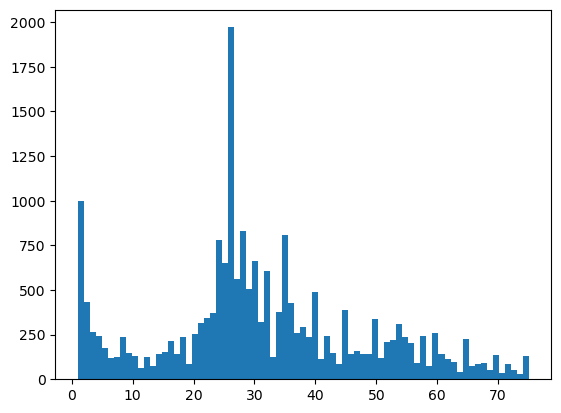

In [4]:
plt.hist(train_age, bins = 75)

In [4]:
from sklearn.utils import class_weight # calculating weights used in ResNet model
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(train_age),
                                                  y = train_age)
w = {key+1: value for (key, value) in enumerate(class_weights)}
w[0] = 0
w


{1: 0.2742342342342342,
 2: 0.6341666666666667,
 3: 1.0456488549618321,
 4: 1.1227868852459015,
 5: 1.5477966101694915,
 6: 2.3415384615384616,
 7: 2.227317073170732,
 8: 1.1707692307692308,
 9: 1.8386577181208055,
 10: 2.0598496240601505,
 11: 4.348571428571429,
 12: 2.245573770491803,
 13: 3.752876712328767,
 14: 1.9158041958041958,
 15: 1.8023684210526316,
 16: 1.2624884792626727,
 17: 1.9292957746478874,
 18: 1.1707692307692308,
 19: 3.1131818181818183,
 20: 1.07015625,
 21: 0.8669620253164557,
 22: 0.7963953488372093,
 23: 0.7344772117962467,
 24: 0.3507810499359795,
 25: 0.4201840490797546,
 26: 0.13899543378995433,
 27: 0.4874733096085409,
 28: 0.3296750902527076,
 29: 0.5403550295857988,
 30: 0.4138368580060423,
 31: 0.856125,
 32: 0.4528264462809917,
 33: 2.1742857142857144,
 34: 0.7325133689839572,
 35: 0.3394795539033457,
 36: 0.6386013986013986,
 37: 1.049655172413793,
 38: 0.9446896551724138,
 39: 1.1608474576271186,
 40: 0.5637037037037037,
 41: 2.382260869565217,
 42: 1.

# Resnet (our final ResNet model)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=12,
                                                  mode='min',
                                                  restore_best_weights=True)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.resnet50.preprocess_input



base_model = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)
base_model.trainable = False


#preprocessing layers + augmentations
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)

x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)



model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

history = model.fit(train_image, train_age, batch_size=32,
                    epochs = 100, validation_split = 0.1,
                    callbacks = [early_stopping],
                    class_weight = w)




Epoch 1/100
578/578 [==============================] - 83s 138ms/step - loss: 13.9985 - accuracy: 0.0426 - val_loss: 7.9780 - val_accuracy: 0.0428
Epoch 2/100
578/578 [==============================] - 78s 136ms/step - loss: 9.7831 - accuracy: 0.0485 - val_loss: 7.6483 - val_accuracy: 0.0428
Epoch 3/100
578/578 [==============================] - 78s 136ms/step - loss: 9.5439 - accuracy: 0.0483 - val_loss: 7.6107 - val_accuracy: 0.0423
Epoch 4/100
578/578 [==============================] - 78s 136ms/step - loss: 9.2745 - accuracy: 0.0480 - val_loss: 8.1673 - val_accuracy: 0.0423
Epoch 5/100
578/578 [==============================] - 78s 136ms/step - loss: 8.9818 - accuracy: 0.0481 - val_loss: 7.4258 - val_accuracy: 0.0404
Epoch 6/100
578/578 [==============================] - 79s 136ms/step - loss: 8.8289 - accuracy: 0.0484 - val_loss: 7.3860 - val_accuracy: 0.0423
Epoch 7/100
578/578 [==============================] - 78s 136ms/step - loss: 8.6491 - accuracy: 0.0489 - val_loss: 7.3052 

NameError: name 'pickle' is not defined

In [10]:
# Save history to file 
filename = 'fits_enhanced/ResNet50_color_model.sav'
pickle.dump(history, open(filename, 'wb'))
log_dir = "logs_enhanced/age_ResNet50_utk/fit/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
model.save(log_dir)

INFO:tensorflow:Assets written to: ram://4b6254e4-c799-4c17-8d32-6aade0842d8e/assets


INFO:tensorflow:Assets written to: ram://4b6254e4-c799-4c17-8d32-6aade0842d8e/assets


INFO:tensorflow:Assets written to: logs_enhanced/age_ResNet50_utk/fit/2023_01_23-19_22_40\assets


INFO:tensorflow:Assets written to: logs_enhanced/age_ResNet50_utk/fit/2023_01_23-19_22_40\assets


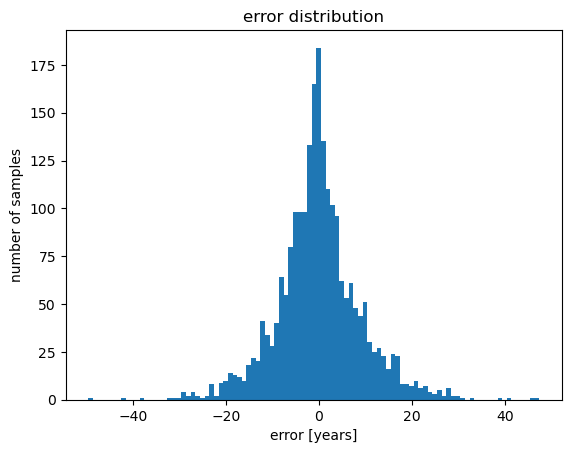

In [24]:
error = test_age - prediction.flatten() # error ditribution 
plt.hist(error, bins = np.arange(min(error), max(error) + 1, 1))
plt.title('error distribution')
plt.xlabel('error [years]')
plt.ylabel('number of samples')
plt.show()

### Verifying model

In [11]:
filename = 'logs_enhanced/age_ResNet50_utk/fit/date/'
model = load_model(filename)
prediction = model.predict(x = test_image, batch_size = 10, verbose = 0) # make predictions based on model

In [41]:
pred = prediction.flatten()
tes = np.array(test_age)
error = np.subtract(pred, tes)
mae = np.mean(np.abs(error))
mae # MAE

6.0442986

In [42]:
pred = prediction.flatten()
tes = np.array(test_age)
error = np.subtract(pred, tes)
error = np.divide(error, tes)
mape = np.mean(np.abs(error))
mape # MAPE 31.06%

0.3106277

In [43]:
invalid_prediction = []
invalid_prediction_age = []
invalid_age = []
for i in range(0, len(prediction)):
    if abs(prediction[i] - test_age[i]) > 10:
        invalid_prediction.append(test_image[i])
        invalid_prediction_age.append(prediction[i])
        invalid_age.append(test_age[i])
        
        
        
        
invalid_prediction = np.array(invalid_prediction)
invalid_prediction_age = np.array(invalid_prediction_age, dtype = np.uint8)
invalid_age = np.array(invalid_age, dtype = np.uint8)

(array([ 1.,  1.,  0.,  0.,  1.,  2.,  1.,  0.,  3.,  3.,  2.,  0.,  1.,
         3.,  5.,  0.,  0.,  4.,  5.,  0.,  3.,  2.,  1.,  0.,  0.,  3.,
         0., 11.,  6.,  8.,  0., 12., 18., 43.,  0., 15., 14., 11.,  0.,
         8.,  9., 10.,  0.,  3.,  6., 14.,  0.,  8.,  5.,  0.,  3.,  5.,
        11.,  0.,  4.,  5.,  5.,  0.,  5.,  9.,  2.,  0.,  2.,  4.,  2.,
         0.,  9.,  7.,  8.,  0.,  3., 11.,  8.,  0., 10.,  4.,  0.,  7.,
         2., 11.,  0.,  5.,  4.,  3.,  0.,  1., 17.,  2.,  0.,  4.,  5.,
         0.,  0.,  9.,  0.,  3.,  0.,  2.,  3., 12.]),
 array([ 1.  ,  1.74,  2.48,  3.22,  3.96,  4.7 ,  5.44,  6.18,  6.92,
         7.66,  8.4 ,  9.14,  9.88, 10.62, 11.36, 12.1 , 12.84, 13.58,
        14.32, 15.06, 15.8 , 16.54, 17.28, 18.02, 18.76, 19.5 , 20.24,
        20.98, 21.72, 22.46, 23.2 , 23.94, 24.68, 25.42, 26.16, 26.9 ,
        27.64, 28.38, 29.12, 29.86, 30.6 , 31.34, 32.08, 32.82, 33.56,
        34.3 , 35.04, 35.78, 36.52, 37.26, 38.  , 38.74, 39.48, 40.22,
        

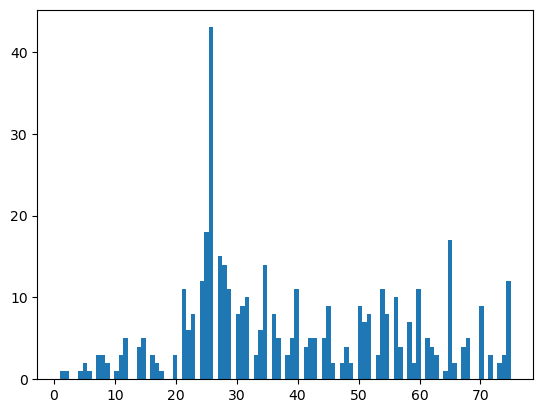

In [52]:
plt.hist(invalid_age, bins = 100) # histogram of errors bigger than 10 years

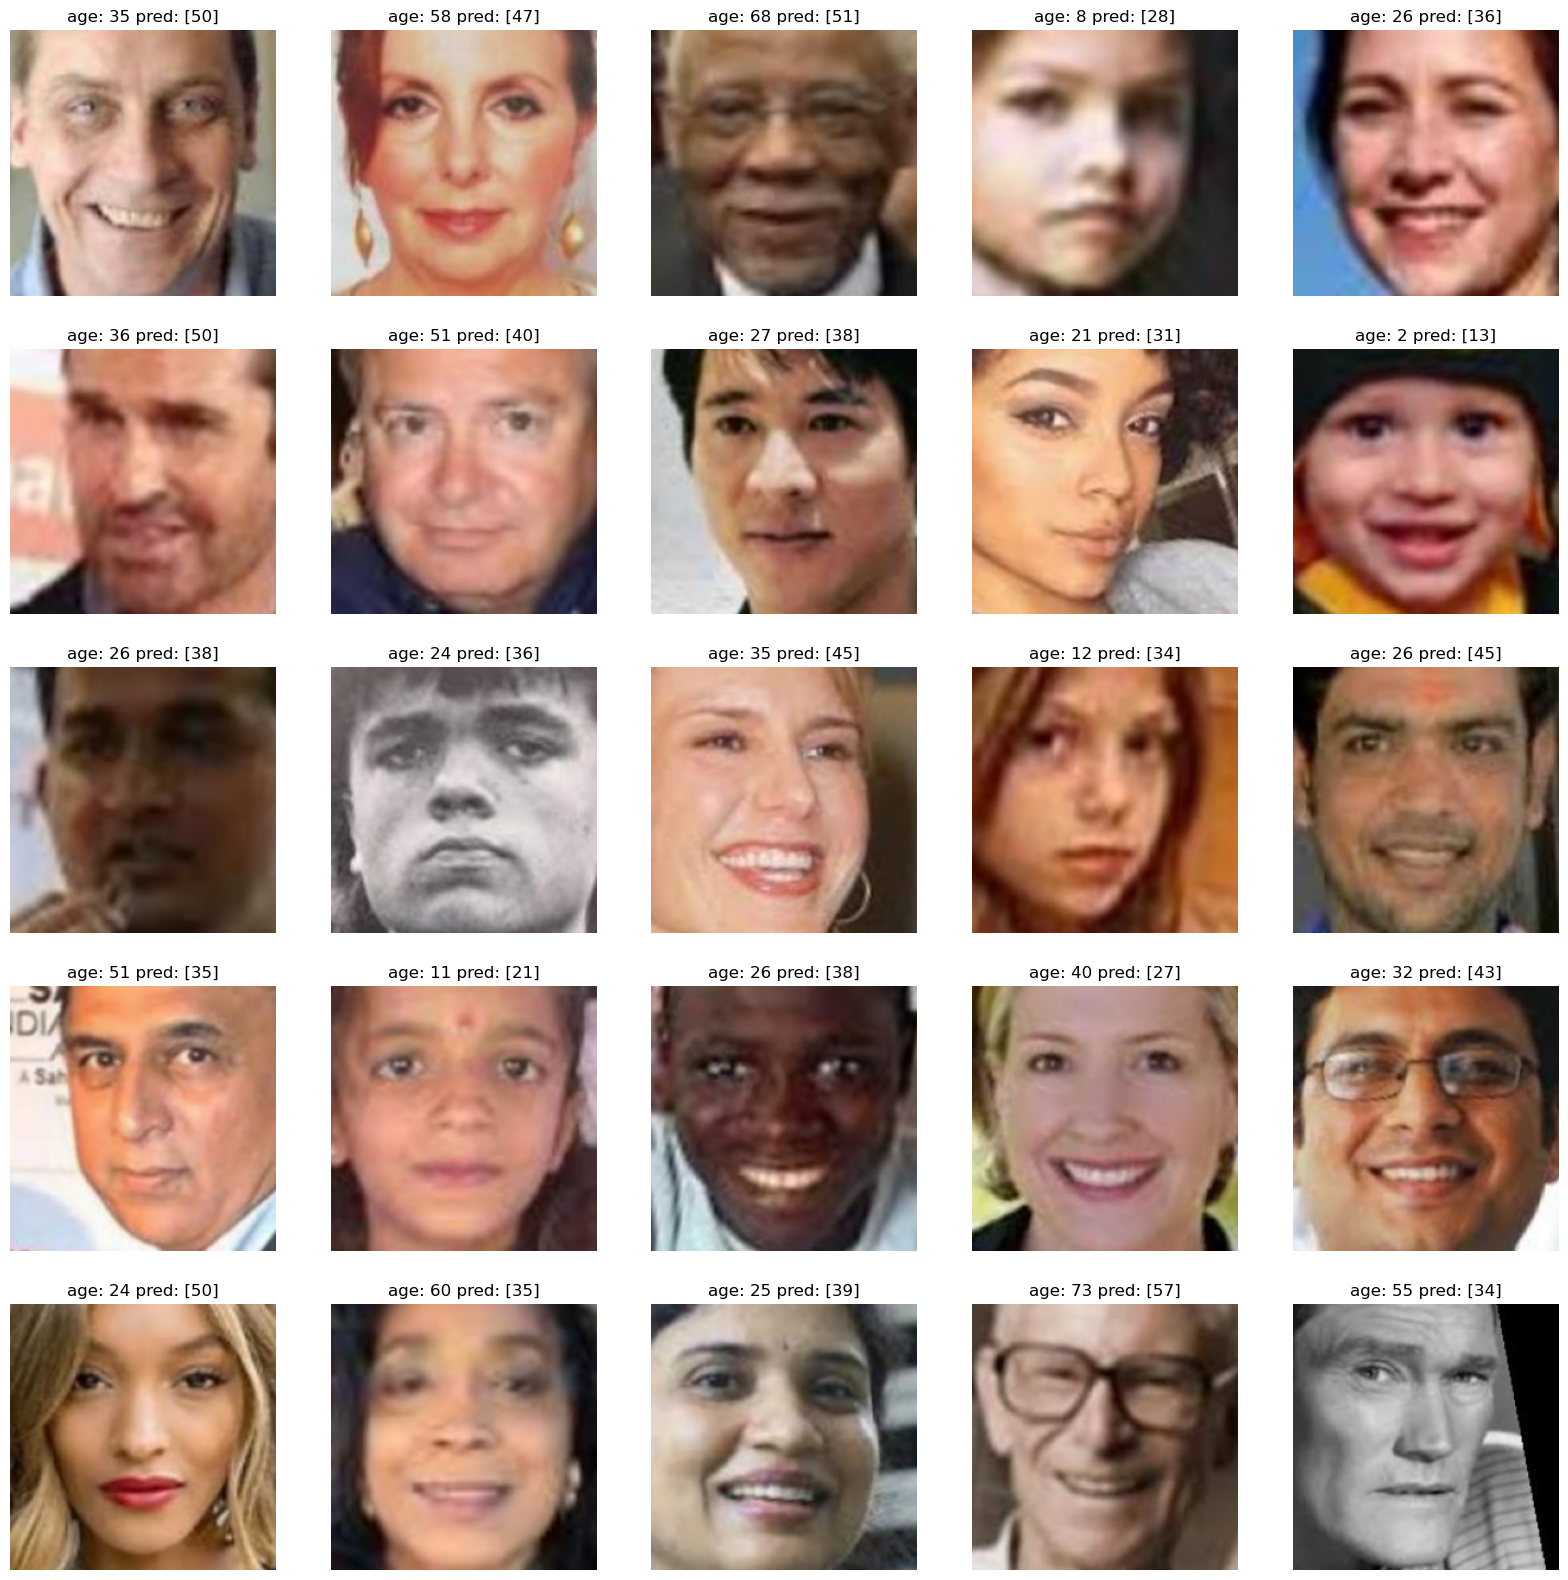

In [47]:
plotImages(invalid_prediction, invalid_prediction_age, invalid_age) # some images with error higher than 10 years

In [4]:
def plotImages(image, predicted_age, real_age): # function used to plot images above
    plt.figure(figsize=(20,20)) # specifying the overall grid size
    for i in range(25):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        plt.axis('off')
        plt.imshow(image[i])
        x = np.round(predicted_age[i], 2)
        plt.title(f"age: {real_age[i]} pred: {str(x)}");
    plt.show()




# mobilenet model prediction without weights (one of two final MobileNet models)

In [5]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=12,
                                                  mode='min',
                                                  restore_best_weights=True)



#preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

    
base_model = MobileNetV3Large(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  
base_model.trainable = False

#preprocessing layers + augmentations
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

history = model.fit(train_image, train_age, batch_size=32,
                    epochs = 100, validation_split = 0.1,
                    callbacks = [early_stopping])

# Save history to file 
filename = 'fits_enhanced/MobileNetV3Large_color_model.sav'
pickle.dump(history, open(filename, 'wb'))
log_dir = "logs_enhanced/age_MobileNetV3Large_utk/fit/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
model.save(log_dir)

Epoch 1/100
578/578 [==============================] - 81s 132ms/step - loss: 11.2837 - accuracy: 0.0441 - val_loss: 7.7962 - val_accuracy: 0.0428
Epoch 2/100
578/578 [==============================] - 76s 132ms/step - loss: 8.5009 - accuracy: 0.0479 - val_loss: 7.5702 - val_accuracy: 0.0428
Epoch 3/100
578/578 [==============================] - 76s 131ms/step - loss: 8.1352 - accuracy: 0.0490 - val_loss: 7.3595 - val_accuracy: 0.0428
Epoch 4/100
578/578 [==============================] - 76s 132ms/step - loss: 7.9986 - accuracy: 0.0489 - val_loss: 7.1745 - val_accuracy: 0.0428
Epoch 5/100
578/578 [==============================] - 76s 131ms/step - loss: 7.8081 - accuracy: 0.0491 - val_loss: 7.1655 - val_accuracy: 0.0428
Epoch 6/100
578/578 [==============================] - 75s 130ms/step - loss: 7.7455 - accuracy: 0.0492 - val_loss: 7.4037 - val_accuracy: 0.0428
Epoch 7/100
578/578 [==============================] - 76s 132ms/step - loss: 7.5573 - accuracy: 0.0492 - val_loss: 6.9643 

INFO:tensorflow:Assets written to: ram://9911c95c-8a87-4dff-8ad5-3e1178cc5a18/assets


INFO:tensorflow:Assets written to: ram://9911c95c-8a87-4dff-8ad5-3e1178cc5a18/assets


INFO:tensorflow:Assets written to: logs_enhanced/age_MobileNetV3Large_utk/fit/2023_01_23-21_17_13\assets


INFO:tensorflow:Assets written to: logs_enhanced/age_MobileNetV3Large_utk/fit/2023_01_23-21_17_13\assets


### Verifying model without weights

In [6]:
filename = 'logs_enhanced/age_MobileNetV3Large_utk/fit/no_weights/'
model_mobile_no = load_model(filename)
prediction_no = model_mobile_no.predict(x = test_image, batch_size = 10, verbose = 0)

In [7]:
pred_no = prediction_no.flatten()
tes_no = np.array(test_age)
error_no = np.subtract(pred_no, tes_no)
mae_no = np.mean(np.abs(error_no))
mae_no #MAE

5.7447762

In [8]:
pred_no = prediction_no.flatten()
tes_no = np.array(test_age)
error_no = np.subtract(pred_no, tes_no)
error_no = np.divide(error_no, tes_no)
mape_no = np.mean(np.abs(error_no))
mape_no #MAPE 30.89%

0.30891335

In [9]:
invalid_prediction = []
invalid_prediction_age = []
invalid_age = []
for i in range(0, len(prediction_no)):
    if abs(prediction_no[i] - test_age[i]) > 10:
        invalid_prediction.append(test_image[i])
        invalid_prediction_age.append(prediction_no[i])
        invalid_age.append(test_age[i])
        
        
        
        
invalid_prediction = np.array(invalid_prediction)
invalid_prediction_age = np.array(invalid_prediction_age, dtype = np.uint8)
invalid_age = np.array(invalid_age, dtype = np.uint8)

(array([ 3.,  3.,  2.,  0.,  4.,  5.,  4.,  0.,  3.,  4.,  2.,  0.,  4.,
         3., 10.,  0.,  0.,  5.,  5.,  0.,  3.,  4.,  2.,  0.,  2.,  3.,
         0.,  8.,  0.,  1.,  0.,  3.,  8., 12.,  0.,  2., 10.,  4.,  0.,
         4.,  2.,  4.,  0.,  2.,  2.,  7.,  0.,  5.,  6.,  0.,  5.,  3.,
        14.,  0.,  4., 11.,  4.,  0.,  7.,  8.,  7.,  0.,  4.,  3.,  5.,
         0., 12.,  9.,  7.,  0.,  2., 11.,  6.,  0., 10.,  4.,  0., 10.,
         4., 12.,  0.,  4.,  4.,  4.,  0.,  2., 15.,  3.,  0.,  2.,  7.,
         2.,  0.,  7.,  1.,  1.,  0.,  2.,  5., 13.]),
 array([ 1.  ,  1.74,  2.48,  3.22,  3.96,  4.7 ,  5.44,  6.18,  6.92,
         7.66,  8.4 ,  9.14,  9.88, 10.62, 11.36, 12.1 , 12.84, 13.58,
        14.32, 15.06, 15.8 , 16.54, 17.28, 18.02, 18.76, 19.5 , 20.24,
        20.98, 21.72, 22.46, 23.2 , 23.94, 24.68, 25.42, 26.16, 26.9 ,
        27.64, 28.38, 29.12, 29.86, 30.6 , 31.34, 32.08, 32.82, 33.56,
        34.3 , 35.04, 35.78, 36.52, 37.26, 38.  , 38.74, 39.48, 40.22,
        

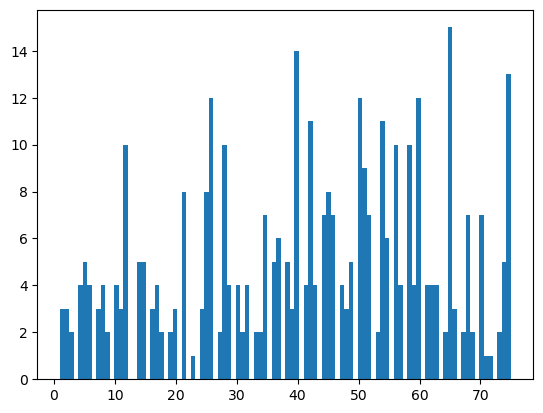

In [10]:
plt.hist(invalid_age, bins = 100) # predictions with error over 10 years

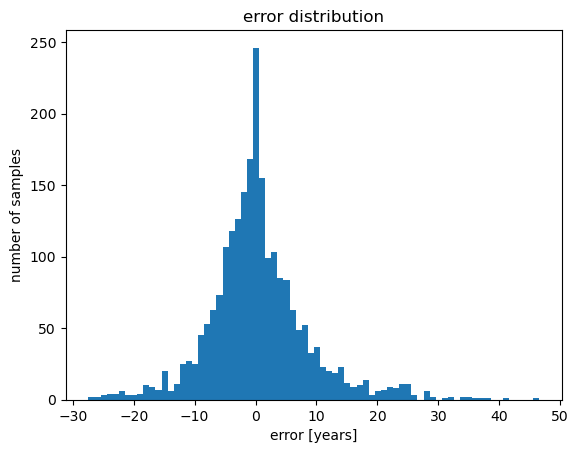

In [12]:
error = test_age - prediction_no.flatten() # prediction error distribution
plt.hist(error, bins = np.arange(min(error), max(error) + 1, 1))
plt.title('error distribution')
plt.xlabel('error [years]')
plt.ylabel('number of samples')
plt.show()

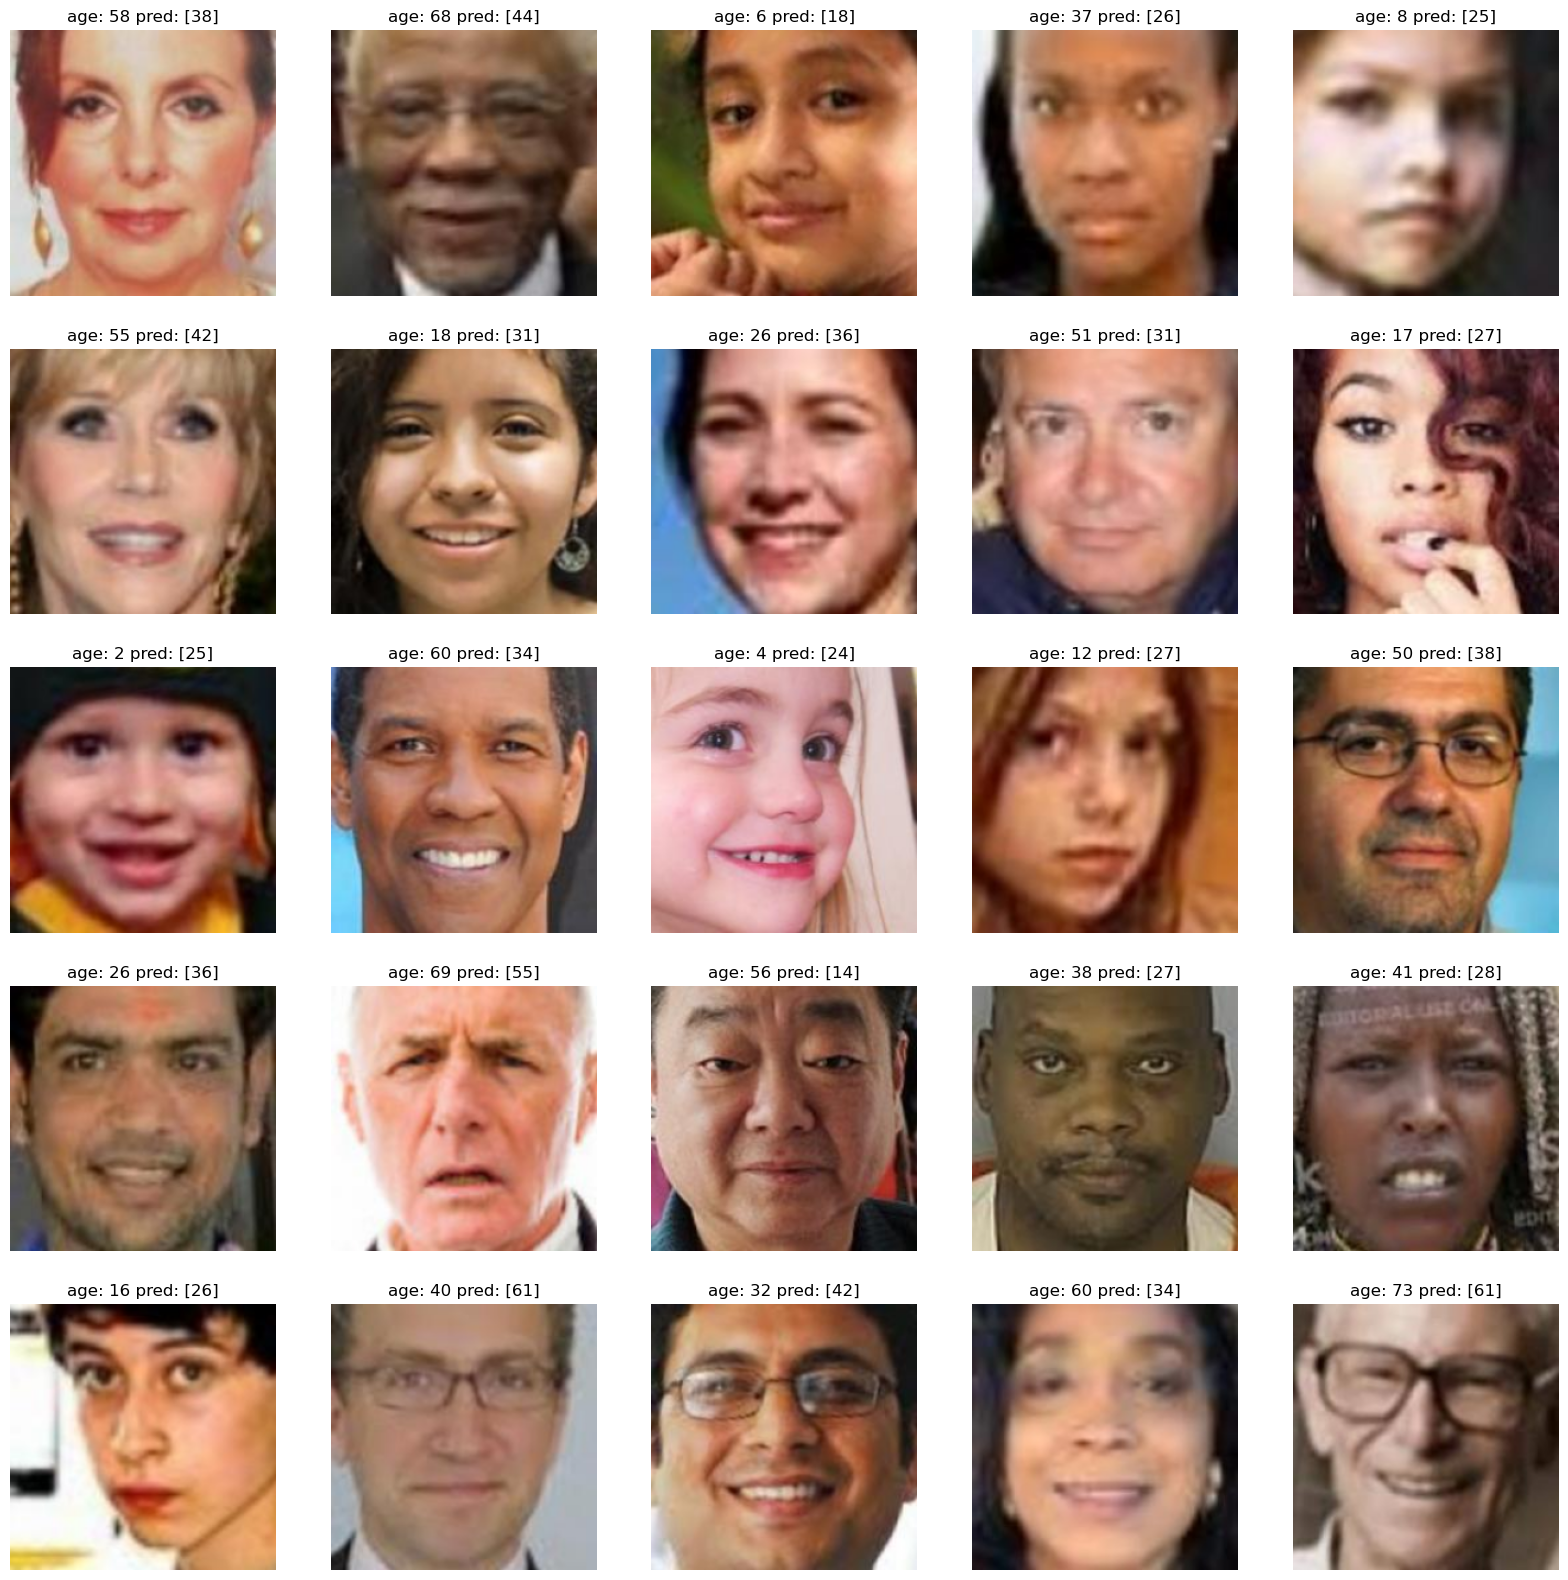

In [11]:
plotImages(invalid_prediction, invalid_prediction_age, invalid_age) # wrongly predicted ages, error bigger than 10 years

### Verifying model with weights (code used was the same as one presented before for MobileNet, the only difference was adding custom weights in model.fit)

In [13]:
filename = 'logs_enhanced/age_MobileNetV3Large_utk/fit/weights/'
model_mobile_yes = load_model(filename)
prediction_yes = model_mobile_yes.predict(x = test_image, batch_size = 10, verbose = 0)

In [15]:
pred_yes = prediction_yes.flatten()
tes_yes = np.array(test_age)
error_yes = np.subtract(pred_yes, tes_yes)
mae_yes = np.mean(np.abs(error_yes))
mae_yes #MAE

6.42988

In [16]:
pred_yes = prediction_yes.flatten()
tes_yes = np.array(test_age)
error_yes = np.subtract(pred_yes, tes_yes)
error_yes = np.divide(error_yes, tes_yes)
mape_yes = np.mean(np.abs(error_yes))
mape_yes #MAPE 36.62%

0.36627817

In [17]:
invalid_prediction = []
invalid_prediction_age = []
invalid_age = []
for i in range(0, len(prediction_yes)):
    if abs(prediction_yes[i] - test_age[i]) > 10:
        invalid_prediction.append(test_image[i])
        invalid_prediction_age.append(prediction_yes[i])
        invalid_age.append(test_age[i])
        
        
        
        
invalid_prediction = np.array(invalid_prediction)
invalid_prediction_age = np.array(invalid_prediction_age, dtype = np.uint8)
invalid_age = np.array(invalid_age, dtype = np.uint8)

(array([ 3.,  4.,  1.,  0.,  3.,  7.,  2.,  0.,  2.,  3.,  1.,  0.,  1.,
         1.,  5.,  0.,  0.,  1.,  3.,  0.,  2.,  3.,  1.,  0.,  1.,  2.,
         0., 11.,  1.,  1.,  0.,  7., 13., 39.,  0., 16., 19., 12.,  0.,
        10.,  9., 17.,  0.,  6., 10., 26.,  0., 13.,  9.,  0., 11.,  7.,
        17.,  0.,  2.,  6.,  4.,  0.,  4.,  7.,  6.,  0.,  5.,  5.,  4.,
         0.,  7.,  5.,  6.,  0.,  3., 12.,  5.,  0., 11.,  4.,  0.,  9.,
         2., 12.,  0.,  6.,  1.,  4.,  0.,  1., 16.,  3.,  0.,  4.,  7.,
         2.,  0., 12.,  2.,  1.,  0.,  1.,  3., 14.]),
 array([ 1.  ,  1.74,  2.48,  3.22,  3.96,  4.7 ,  5.44,  6.18,  6.92,
         7.66,  8.4 ,  9.14,  9.88, 10.62, 11.36, 12.1 , 12.84, 13.58,
        14.32, 15.06, 15.8 , 16.54, 17.28, 18.02, 18.76, 19.5 , 20.24,
        20.98, 21.72, 22.46, 23.2 , 23.94, 24.68, 25.42, 26.16, 26.9 ,
        27.64, 28.38, 29.12, 29.86, 30.6 , 31.34, 32.08, 32.82, 33.56,
        34.3 , 35.04, 35.78, 36.52, 37.26, 38.  , 38.74, 39.48, 40.22,
        

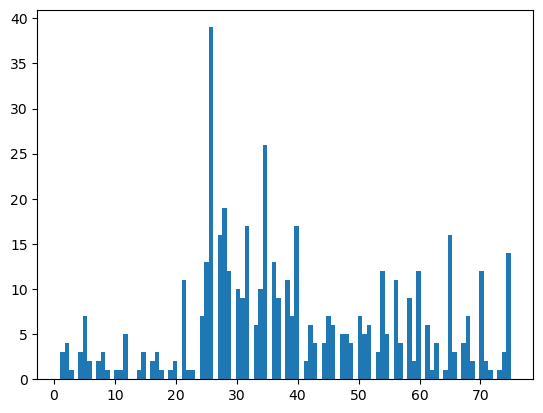

In [18]:
plt.hist(invalid_age, bins = 100) # predictions with error bigger than 10 years, histogram

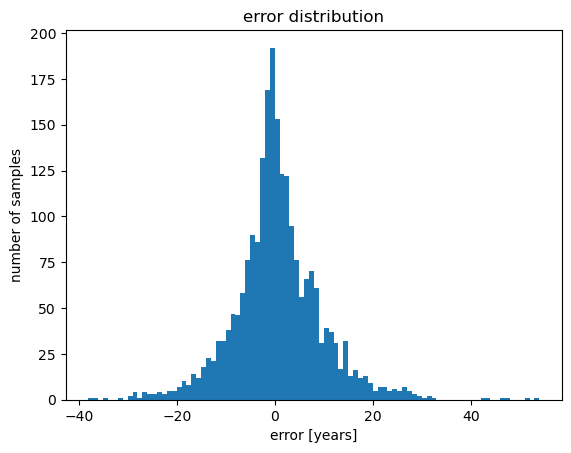

In [19]:
error = test_age - prediction_yes.flatten() # prediction error distribution
plt.hist(error, bins = np.arange(min(error), max(error) + 1, 1))
plt.title('error distribution')
plt.xlabel('error [years]')
plt.ylabel('number of samples')
plt.show()

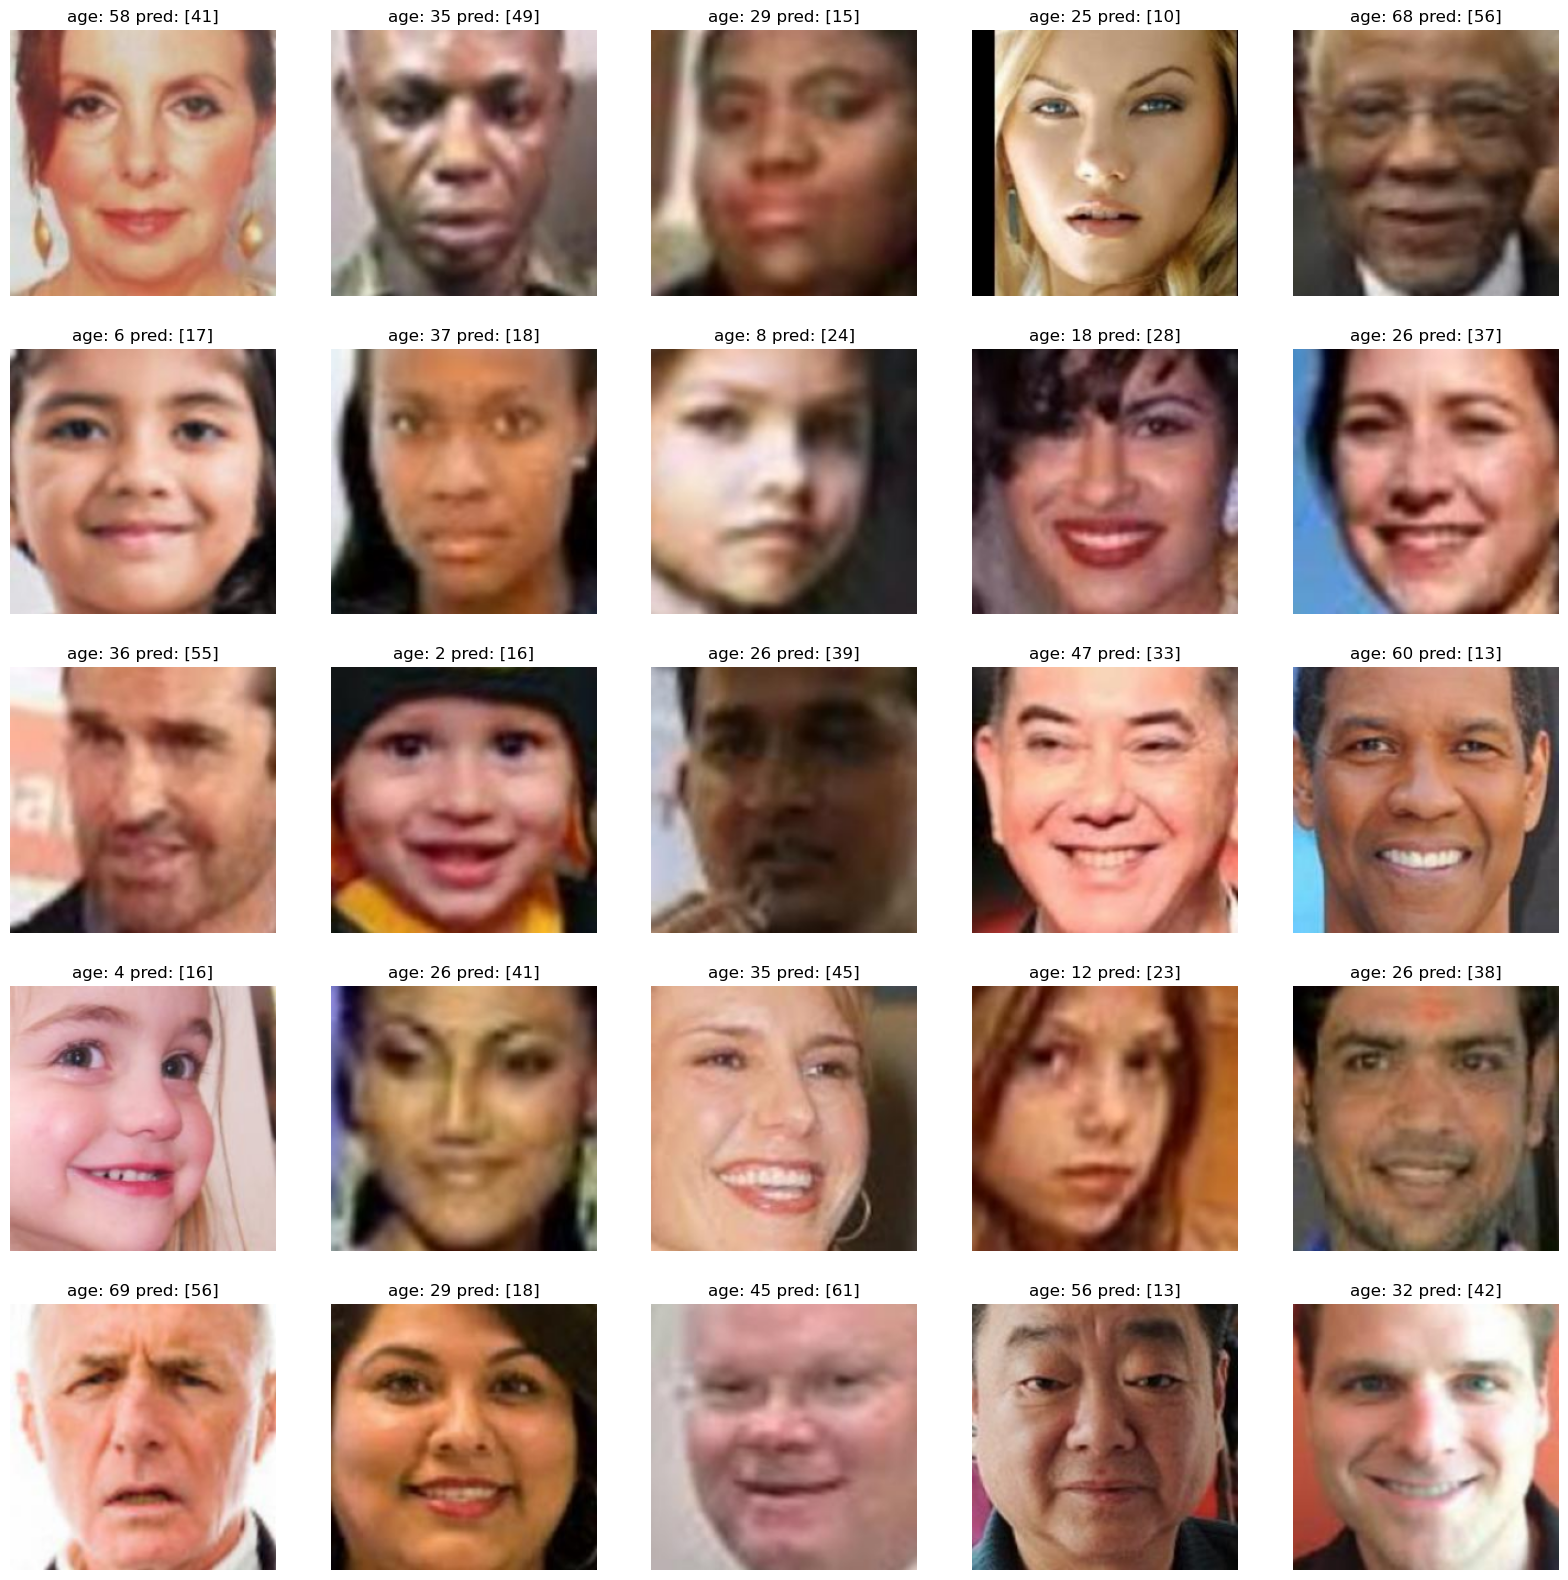

In [20]:
plotImages(invalid_prediction, invalid_prediction_age, invalid_age) # wrongly predicted ages with error bigger than 10 years